# Human-Mammalian Brain - Basal Ganglia 10X snRANSeq analysis: clustering and annotations

The basal ganglia (BG) are a system of interconnected brain structures that play a crucial role in motor control, learning, behavior, and emotion. With approximately 200 million neurons in the human basal ganglia alone, these structures are involved in a wide range of neurological processes and are implicated in numerous disorders affecting human health, including Parkinson’s disease, Huntington’s disease, and substance abuse disorders. To further understand the complexity of the basal ganglia, researchers have historically classified its neurons into various types based on their cytoarchitecture, connectivity, molecular profile, and functional properties. However, recent advancements in high-throughput transcriptomic profiling have revolutionized our ability to systematically categorize these cell types within species, while the maturation of machine learning technologies have enabled the integration of these taxonomies across species.

Our **consensus basal ganglia cell type taxonomy** is the result of iterative clustering and cross-species integration of transcriptomic data. The taxonomy encompasses neurons from key structures within the basal ganglia, including the caudate (Ca), putamen (Pu), nucleus accumbens (NAc), the external and internal segments of the globus pallidus (GPe, GPi), subthalamic nucleus (STN), and substantia nigra (SN). By combining data from multiple primate and rodent species, we have developed a consensus taxonomy that highlights both conserved and species-specific cell types. We validate our taxonomy through marker gene expression analysis, comparison with previously published taxonomies, and self-projection, ensuring the accuracy and robustness of each level in the taxonomic hierarchy.

You need to be connected to the internet to run this notebook or connected to a cache that has the HMBA-BG data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the  [``general_acessing_10x_snRNASeq_tutorial.ipynb``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) tutorial/example. In a related tutorial, we also show how to access and use [HMBA-BG gene expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_10X_snRNASeq_tutorial.html).

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object downloads data requested by the user, tracks which files have already been downloaded to your local system, and serves the path to the requested data on disk. For metadata, the cache can also directly serve a up a Pandas DataFrame. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you would like to download the data to your system.**

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(
    download_base,
    s3_bucket='allen-brain-cell-atlas-staging',
    auth_required=True
)

abc_cache.current_manifest

'releases/20250630/manifest.json'

## Data overview

We'll quickly walk through the data we will be using in this notebook. The HMBA-BG 10X datasets are located across several directories listed in the `ABCProjectCache`. In this notebook, we will be looking at the Aligned HMBA-BG 10X dataset. These data combine the there species with an aligned set of ~16k across the species. We will be using data and metadata from the following directories:
- HMBA-10xMultiome-BG-Aligned
- HMBA-BG-taxonomy-CCN20250428

Note that data for each individual species is available in the directory `HMBA-10xMultiome-BG-Aligned`.

Below we list the data and metadata in the HMBA-10xMultiome-BG-Aligned dataset.

In [3]:
print("HMBA-10xMultiome-BG-Aligned: gene expression data (h5ad)\n\t", abc_cache.list_expression_matrix_files(directory='HMBA-10xMultiome-BG-Aligned'))
print("HMBA-10xMultiome-BG-Aligned: metadata (csv)\n\t", abc_cache.list_metadata_files(directory='HMBA-10xMultiome-BG-Aligned'))

HMBA-10xMultiome-BG-Aligned: gene expression data (h5ad)
	 ['HMBA-10xMultiome-BG-Aligned/log2', 'HMBA-10xMultiome-BG-Aligned/raw']
HMBA-10xMultiome-BG-Aligned: metadata (csv)
	 ['cell_metadata', 'donor', 'example_gene_expression', 'gene', 'library', 'value_sets']


We will also use metadata from the HMBA-BG taxonomy directory. Below is the list of available files:

In [4]:
print("HMBA-BG-taxonomy-CCN20250428: metadata (csv)\n\t", abc_cache.list_metadata_files(directory='HMBA-BG-taxonomy-CCN20250428'))

HMBA-BG-taxonomy-CCN20250428: metadata (csv)
	 ['abbreviation_term', 'cell_2d_embedding_coordinates', 'cell_to_cluster_membership', 'cluster', 'cluster_annotation_term', 'cluster_annotation_term_set', 'cluster_annotation_to_abbreviation_map', 'cluster_to_cluster_annotation_membership']


### Cell metadata

Essential cell metadata is stored as a CSV file that we load as a Pandas DataFrame. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. This metadata file contains cells across all species in the HMBA-BG dataset.

Each cell is associated with a *library label*, *donor label*, *alignment_job_id*, *feature_matrix_label* and *dataset_label* identifying which data package this cell is part of. This metadata file will be combined with other metadata files that ship with this package to add information associated with the donor, UMAP coordinates, cluster assignments, and more.

Below, we load the first of the metadata used in this tutorial. This represents the cell metadata for the aligned dataset.

The command we use below both downloads the data if it is not already available in the local cache and loads the data as a Pandas DataFrame. This pattern of loading metadata is repeated throughout the tutorials.

In [5]:
cell = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='cell_metadata',
    dtype={'cell_label': str}
).set_index('cell_label')
print("Number of cells = ", len(cell))
cell.head()

/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:643: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


Number of cells =  1896133


cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027    15259.0   
AAACAGCCAATTGAGA-2362_A05       0.054795    20645.0   
AAACAGCCAGCATGTC-2362_A05       0.000000     2551.0   
AAACAGCCATTGACAT-2362_A05       0.000000     2341.0   
AAACAGCCATTGTGGC-2362_A05       0.027397     8326.0   

                                  feature_matrix_label  \
cell_label                                               
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Aligned   

                                         dataset_label  \
cell_label                                               
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Aligned   

                                                  abc_sample_id  
cell_label                                                       
AAACAGCCAAATGCCC-2362_A05  38447b19-a5dc-4eca-9021-56ae191e8809  
AAACAGCCAATTGAGA-2362_A05  3dc4dc1f-4b8a-4012-bb07-e3906ad70da0  
AAACAGCCAGCATGTC-2362_A05  291d6ebf-ca70-4d9d-8dde-10fa841dba93  
AAACAGCCATTGACAT-2362_A05  12153419-9b49-4d5f-a10d-ddb7837a729d  
AAACAGCCATTGTGGC-2362_A05  5716499d-d69d-489e-b4ed-6841b6ba051d

We can use pandas `groupby` function to see how many unique items are associated for each field and list them out if the number of unique items is small.

In [6]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [7]:
print_column_info(cell)

Number of unique cell_barcode = 680274 
Number of unique donor_label = 22 ['CJ23.56.002', 'CJ23.56.003', 'CJ24.56.001', 'CJ24.56.004', 'H18.30.001', 'H19.30.004', 'H20.30.001', 'H20.30.002', 'H21.30.004', 'H23.30.001', 'H24.30.001', 'H24.30.003', 'H24.30.004', 'H24.30.007', 'Q19.26.010', 'Q21.26.002', 'Q21.26.010', 'QM21.26.001', 'QM21.26.003', 'QM23.50.001', 'QM23.50.002', 'QM23.50.003']
Number of unique barcoded_cell_sample_label = 417 
Number of unique library_label = 417 
Number of unique alignment_job_id = 303 
Number of unique doublet_score = 1422 
Number of unique umi_count = 85704 
Number of unique feature_matrix_label = 1 ['HMBA-10xMultiome-BG-Aligned']
Number of unique dataset_label = 1 ['HMBA-10xMultiome-BG-Aligned']
Number of unique abc_sample_id = 1863243 


### Donor and Library metadata

The first two associated metadata we load are the `donor` and `library` tables. The donor table contains species, sex, and age information. The library table contains information on 10X methods and brain region of interest the tissue was extracted from.

In [8]:
donor = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='donor'
).set_index('donor_label')
donor.head()

donor_species species_scientific_name species_genus donor_sex  \
donor_label                                                                   
QM23.50.003  NCBITaxon:9544          Macaca mulatta       Macaque      Male   
QM21.26.001  NCBITaxon:9544          Macaca mulatta       Macaque      Male   
Q19.26.010   NCBITaxon:9544          Macaca mulatta       Macaque    Female   
H24.30.003   NCBITaxon:9606            Homo sapiens         Human    Female   
H21.30.004   NCBITaxon:9606            Homo sapiens         Human      Male   

            donor_age  donor_age_value donor_age_unit  
donor_label                                            
QM23.50.003     6 yrs              6.0          years  
QM21.26.001     6 yrs              6.0          years  
Q19.26.010     10 yrs             10.0          years  
H24.30.003     19 yrs             19.0          years  
H21.30.004     57 yrs             57.0          years

In [9]:
library = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='library'
).set_index('library_label')
library.head()

library_method barcoded_cell_sample_label  \
library_label                                                    
L8XR_240222_21_H03  10xMultiome;GEX                   2077_A02   
L8XR_220428_02_A05  10xMultiome;GEX                   1224_A04   
L8XR_220428_02_C04  10xMultiome;GEX                   1222_A02   
L8XR_240705_01_A06  10xMultiome;GEX                   2305_E01   
L8XR_240919_21_B05  10xMultiome;GEX                   2453_A02   

                                            enrichment_population  \
library_label                                                       
L8XR_240222_21_H03              50% NeuN+, 35% OLIG2-, 15% OLIG2+   
L8XR_220428_02_A05  10% NeuN+, 49% OLIG2-, 25% OLIG2+, 16% Nurr1+   
L8XR_220428_02_C04              60% NeuN+, 27% OLIG2-, 13% OLIG2+   
L8XR_240705_01_A06              50% NeuN+, 35% OLIG2-, 15% OLIG2+   
L8XR_240919_21_B05              70% NeuN+, 20% OLIG2-, 10% OLIG2+   

                   cell_specimen_type parcellation_term_identifier  \
library_label                                                        
L8XR_240222_21_H03             Nuclei                   DHBA:11538   
L8XR_220428_02_A05             Nuclei                   DHBA:12261   
L8XR_220428_02_C04             Nuclei                   DHBA:10466   
L8XR_240705_01_A06             Nuclei                   DHBA:11537   
L8XR_240919_21_B05             Nuclei                   DHBA:10345   

                   region_of_interest_name region_of_interest_label  \
library_label                                                         
L8XR_240222_21_H03          caudal putamen                      PuC   
L8XR_220428_02_A05  ventral tegmental area                      VTA   
L8XR_220428_02_C04     subthalamic nucleus                      STH   
L8XR_240705_01_A06         rostral putamen                      PuR   
L8XR_240919_21_B05        Ventral pallidus                      VeP   

                   anatomical_division_label  donor_label  
library_label                                              
L8XR_240222_21_H03             Basal ganglia  QM23.50.003  
L8XR_220428_02_A05             Basal ganglia  QM21.26.001  
L8XR_220428_02_C04             Basal ganglia   Q19.26.010  
L8XR_240705_01_A06             Basal ganglia   H24.30.003  
L8XR_240919_21_B05             Basal ganglia   H21.30.004

We combine these into an extended cell metadata table.

In [10]:
cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(library, on='library_label', rsuffix='_library_table')

del cell

Below we use a pandas `groupby` to show the number of cells from each species.

In [11]:
cell_extended.groupby('species_genus')[['feature_matrix_label']].count()

feature_matrix_label
species_genus                      
Human                       1034819
Macaque                      548281
Marmoset                     313033

We can also use the `groupby` function to show the number of cells in each region of interest extracted from the BG.

In [12]:
cell_extended.groupby('region_of_interest_name')[['region_of_interest_label']].count()

region_of_interest_label
region_of_interest_name                                               
Ventral pallidus                                                 36512
body of caudate                                                 187160
brain                                                           313033
caudal putamen                                                  166106
caudate nucleus                                                  27672
core of nucleus accumbens                                        19192
external segment of globus pallidus                             204481
globus pallidus                                                   4567
head of caudate                                                 132071
internal segment of globus pallidus                             131680
nucleus accumbens                                               149878
peri-caudate ependymal and subependymal zone                      8376
posteroventral putamen                                           74232
putamen                                                          34951
rostral putamen                                                 196244
shell of nucleus accumbens                                        9385
substantia nigra                                                 33156
subthalamic nucleus                                              58570
tail of caudate                                                  87073
ventral tegmental area                                           21794

### Adding color and feature order

Each feature in the donor and library table comes is associated with unique colors and an ordering with the set of values. Below we load the `value_sets` DataFrame which is a mapping from the various value in the donor and species tables to those colors and orderings. We incorporate these values into the cell metadata table. 

In [13]:
value_sets = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='value_sets'
).set_index('label')
value_sets.head()

table          field description  order external_identifier  \
label                                                                   
Female    donor      donor_sex      Female      1                 NaN   
Male      donor      donor_sex        Male      2                 NaN   
Human     donor  species_genus       Human      1     NCBITaxon:9605    
Macaque   donor  species_genus     Macaque      2     NCBITaxon:9539    
Marmoset  donor  species_genus    Marmoset      3      NCBITaxon:9481   

         parent_label color_hex_triplet comment Column1 Column2 Column3  \
label                                                                     
Female            NaN           #565353     NaN     NaN     NaN     NaN   
Male              NaN           #ADC4C3     NaN     NaN     NaN     NaN   
Human             NaN           #377eb8     NaN     NaN     NaN     NaN   
Macaque           NaN           #4daf4a     NaN     NaN     NaN     NaN   
Marmoset          NaN           #FF5F5D     NaN     NaN     NaN     NaN   

         Column4  
label             
Female       NaN  
Male         NaN  
Human        NaN  
Macaque      NaN  
Marmoset     NaN

We define a convince function to add colors for the various values in the data (e.g. unique region of interest or donor sex values).

In [14]:
def extract_value_set(cell_metadata_df: pd.DataFrame, input_value_set: pd.DataFrame, input_value_set_label: str):
    """Add color and order columns to the cell metadata dataframe based on the input
    value set.

    Columns are added as {input_value_set_label}_color and {input_value_set_label}_order.

    Parameters
    ----------
    cell_metadata_df : pd.DataFrame
        DataFrame containing cell metadata.
    input_value_set : pd.DataFrame
        DataFrame containing the value set information.
    input_value_set_label : str
        The the column name to extract color and order information for. will be added to the cell metadata.
    """
    cell_metadata_df[f'{input_value_set_label}_color'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['color_hex_triplet'].values
    cell_metadata_df[f'{input_value_set_label}_order'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['order'].values

Use our function to add the relevant color and order columns to our cell_metadata table.

In [15]:
# Add region of interest color and order
extract_value_set(cell_extended, value_sets, 'region_of_interest_label')
# Add species common name color and order
extract_value_set(cell_extended, value_sets, 'species_genus')
# Add species scientific name color and order
extract_value_set(cell_extended, value_sets, 'species_scientific_name')
# Add donor sex color and order
extract_value_set(cell_extended, value_sets, 'donor_sex')
cell_extended.head()

cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027    15259.0   
AAACAGCCAATTGAGA-2362_A05       0.054795    20645.0   
AAACAGCCAGCATGTC-2362_A05       0.000000     2551.0   
AAACAGCCATTGACAT-2362_A05       0.000000     2341.0   
AAACAGCCATTGTGGC-2362_A05       0.027397     8326.0   

                                  feature_matrix_label  \
cell_label                                               
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Aligned   

                                         dataset_label  \
cell_label                                               
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Aligned   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Aligned   

                                                  abc_sample_id  ...  \
cell_label                                                       ...   
AAACAGCCAAATGCCC-2362_A05  38447b19-a5dc-4eca-9021-56ae191e8809  ...   
AAACAGCCAATTGAGA-2362_A05  3dc4dc1f-4b8a-4012-bb07-e3906ad70da0  ...   
AAACAGCCAGCATGTC-2362_A05  291d6ebf-ca70-4d9d-8dde-10fa841dba93  ...   
AAACAGCCATTGACAT-2362_A05  12153419-9b49-4d5f-a10d-ddb7837a729d  ...   
AAACAGCCATTGTGGC-2362_A05  5716499d-d69d-489e-b4ed-6841b6ba051d  ...   

                          anatomical_division_label donor_label_library_table  \
cell_label                                                                      
AAACAGCCAAATGCCC-2362_A05             Basal ganglia                H24.30.001   
AAACAGCCAATTGAGA-2362_A05             Basal ganglia                H24.30.001   
AAACAGCCAGCATGTC-2362_A05             Basal ganglia                H24.30.001   
AAACAGCCATTGACAT-2362_A05             Basal ganglia                H24.30.001   
AAACAGCCATTGTGGC-2362_A05             Basal ganglia                H24.30.001   

                          region_of_interest_label_color  \
cell_label                                                 
AAACAGCCAAATGCCC-2362_A05                        #53DB33   
AAACAGCCAATTGAGA-2362_A05                        #53DB33   
AAACAGCCAGCATGTC-2362_A05                        #53DB33   
AAACAGCCATTGA

### UMAP spatial embedding

Now that we've merged our donor and library metadata into the main cells data, our next step is to put these values in a Uniform Manifold Approximation and Projection (UMAP) for cells in the dataset. The UMAP is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. 

Below we load this 2-D embedding for a sub selection of our cells and merge the x-y coordinates into the extended cell metadata we are creating. 

In [16]:
cell_2d_embedding_coordinates = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_2d_embedding_coordinates'
).set_index('cell_label')
cell_2d_embedding_coordinates.head()

x          y
cell_label                                    
AAACAGCCAAATGCCC-2362_A05  0.452302   2.938630
AAACAGCCAATTGAGA-2362_A05  0.051495  16.282684
AAACAGCCAGCATGTC-2362_A05 -1.233702   8.666612
AAACAGCCATTGACAT-2362_A05  0.517126  15.368365
AAACAGCCATTGTGGC-2362_A05 -3.697715  -1.647361

In [17]:
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)
cell_extended = cell_extended.sample(frac=1)

del cell_2d_embedding_coordinates

We define a small helper function *plot umap* to visualize the cells on the UMAP. In the examples below we will plot associated cell information colorized by dissection donor species, sex, and region of interest.

In [18]:
def plot_umap(
    xx: np.ndarray,
    yy: np.ndarray,
    cc: np.ndarray = None,
    val: np.ndarray = None,
    fig_width: float = 8,
    fig_height: float = 8,
    cmap: Optional[plt.Colormap] = None,
    labels: np.ndarray = None,
    term_orders: np.ndarray = None,
    colorbar: bool = False,
    sizes: np.ndarray = None
 ) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a scatter plot of the UMAP coordinates.

    Parameters
    ----------
    xx : array-like
        x-coordinates of the points to plot.
    yy : array-like
        y-coordinates of the points to plot.
    cc : array-like, optional
        colors of the points to plot. If None, the points will be colored by the values in `val`.
    val : array-like, optional
        values of the points to plot. If None, the points will be colored by the values in `cc`.
    fig_width : float, optional
        width of the figure in inches. Default is 8.
    fig_height : float, optional
        height of the figure in inches. Default is 8.
    cmap : str, optional
        colormap to use for coloring the points. If None, the points will be colored by the values in `cc`.
    labels : array-like, optional
        labels for the points to plot. If None, no labels will be added to the plot.
    term_orders : array-like, optional
        order of the labels for the legend. If None, the labels will be ordered by their appearance in `labels`.
    colorbar : bool, optional
        whether to add a colorbar to the plot. Default is False.
    sizes : array-like, optional
        sizes of the points to plot. If None, all points will have the same size.
    """
    if sizes is None:
        sizes = 1
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        scatt = ax.scatter(xx, yy, c=val, s=0.5, marker='.', cmap=cmap, alpha=sizes)
    elif cc is not None:
        scatt = ax.scatter(xx, yy, c=cc, s=0.5, marker='.', alpha=sizes)

    if labels is not None:
        from matplotlib.patches import Rectangle
        unique_label_colors = (labels + ',' + cc).unique()
        unique_labels = np.array([label_color.split(',')[0] for label_color in unique_label_colors])
        unique_colors = np.array([label_color.split(',')[1] for label_color in unique_label_colors])

        if term_orders is not None:
            unique_order = term_orders.unique()
            term_order = np.argsort(unique_order)
            unique_labels = unique_labels[term_order]
            unique_colors = unique_colors[term_order]
            
        rects = []
        for color in unique_colors:
            rects.append(Rectangle((0, 0), 1, 1, fc=color))

        legend = ax.legend(rects, unique_labels, loc=1)
        # ax.add_artist(legend)

    if colorbar:
        fig.colorbar(scatt, ax=ax)
    
    return fig, ax

Plot the various donor and library metadata available.

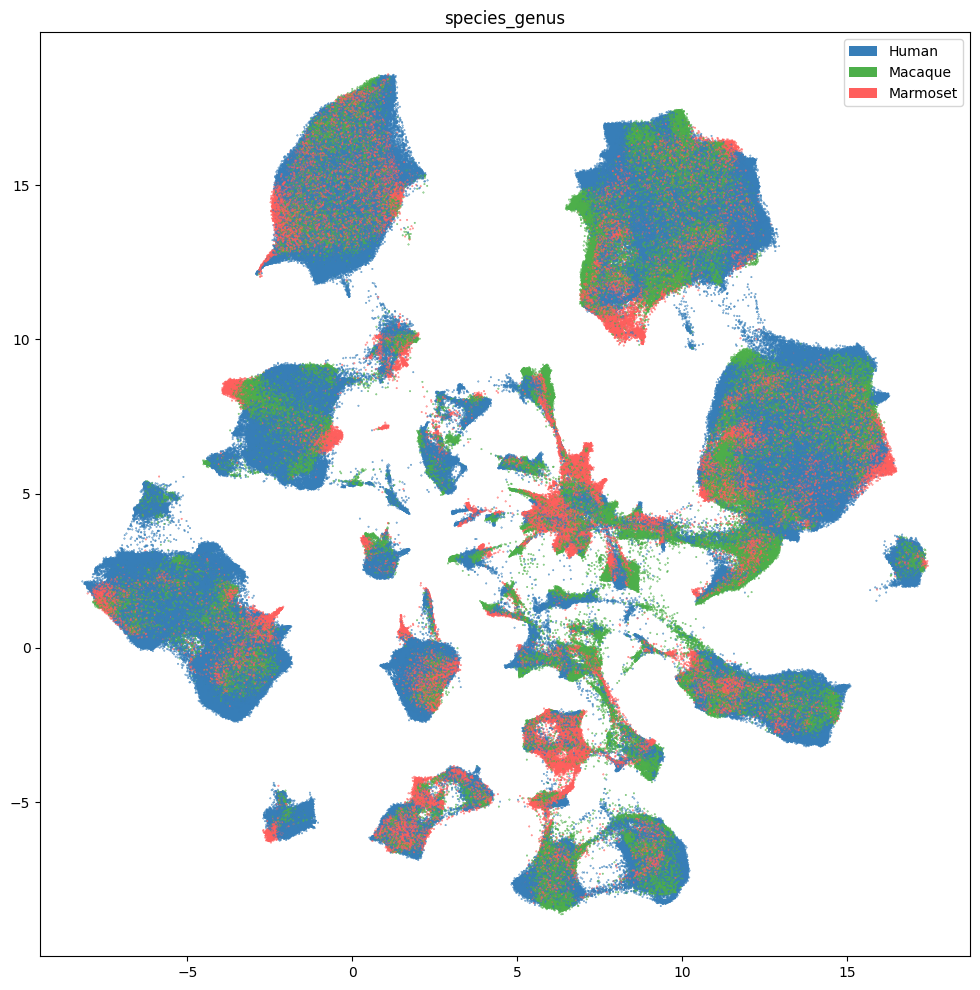

In [19]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['species_genus_color'],
    labels=cell_extended['species_genus'],
    term_orders=cell_extended['species_genus_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("species_genus")
plt.show()

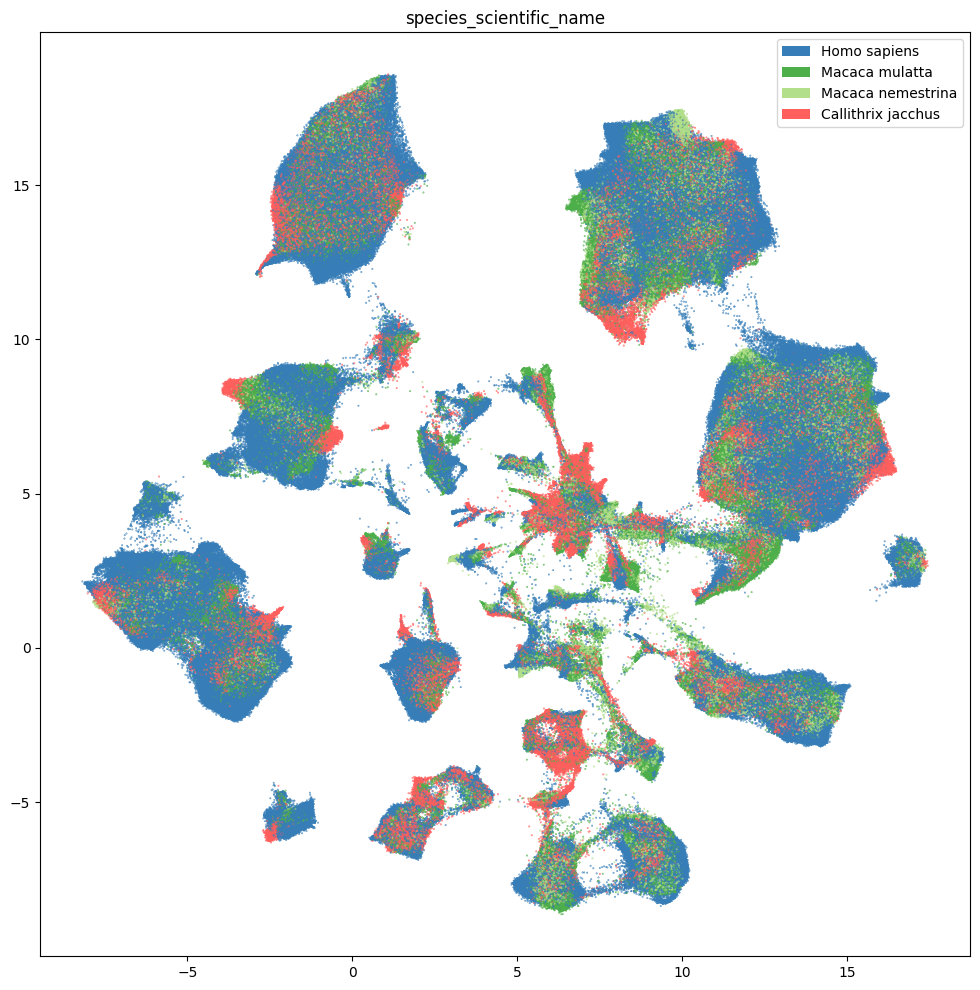

In [20]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['species_scientific_name_color'],
    labels=cell_extended['species_scientific_name'],
    term_orders=cell_extended['species_scientific_name_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("species_scientific_name")
plt.show()

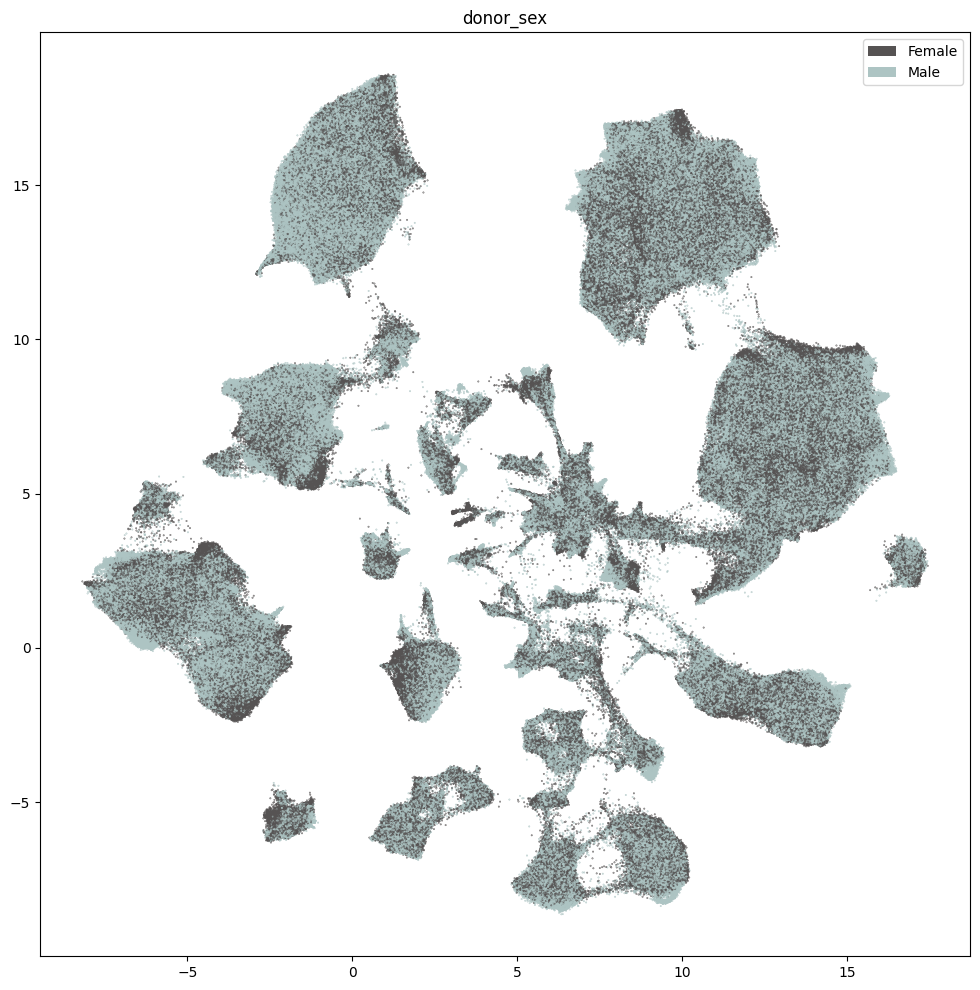

In [21]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['donor_sex_color'],
    labels=cell_extended['donor_sex'],
    term_orders=cell_extended['donor_sex_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("donor_sex")
plt.show()

Below we show the region of interest for the three species. Note, however, that Marmoset does not have fine grained ROIs available and is marked as `Br - Brain`.

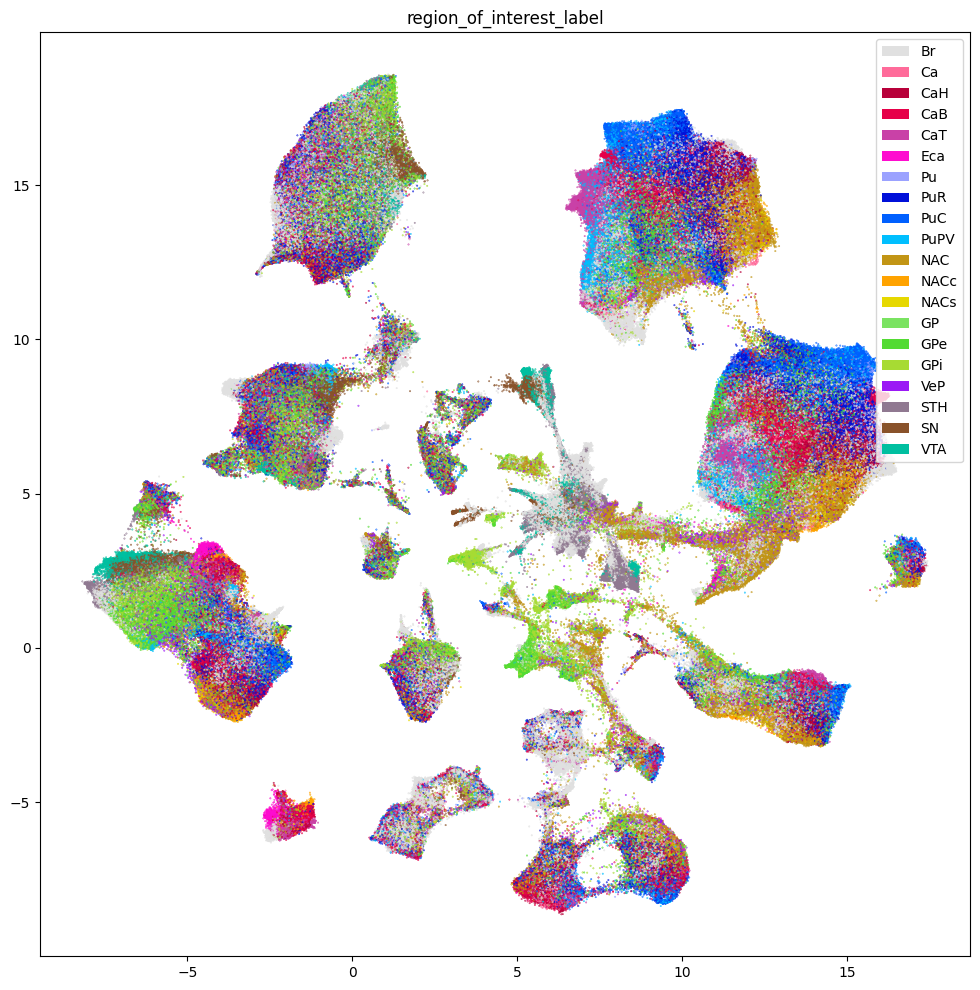

In [22]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['region_of_interest_label_color'],
    labels=cell_extended['region_of_interest_label'],
    term_orders=cell_extended['region_of_interest_label_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("region_of_interest_label")
plt.show()

## Taxonomy Information

The final set of metadata we load into our extended cell metadata file maps the cells into their assigned cluster in the taxonomy. We additionally load metadata for the clusters and compute useful information, such as the number of cells in each taxon at each level of the taxonomy.

First, we load the table that describes the levels in the taxonomy from Neighborhood at the highest to Cluster at the lowest level.

In [23]:
cluster = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster',
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster.head()

cluster_alias  number_of_cells
cluster_annotation_term_label                               
CS20250428_CLUST_0161             Human-143               91
CS20250428_CLUST_0162             Human-145             1783
CS20250428_CLUST_0163             Human-146              172
CS20250428_CLUST_0164             Human-149             2649
CS20250428_CLUST_0165             Human-150             1359

Next, we load information associated with each Cluster in the taxonomy. This includes a useful alias value for each cluster as well as the number of cells in each cluster.

In [24]:
cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})
cluster_annotation_term_set

cluster_annotation_term_label          name   description  order
0           CCN20250428_LEVEL_0  Neighborhood  Neighborhood      0
1           CCN20250428_LEVEL_1         Class         Class      1
2           CCN20250428_LEVEL_2      Subclass      Subclass      2
3           CCN20250428_LEVEL_3         Group         Group      3
4           CCN20250428_LEVEL_4       Cluster       Cluster      4

Finally, for the clusters, we load information on the annotations for each cluster. This also includes the term order and color information which we will use to plot later.

In [25]:
cluster_annotation_term = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term',
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term[cluster_annotation_term['cluster_annotation_term_set_name'] == 'Group']

name  \
cluster_annotation_term_label                        
CS20250428_GROUP_0039                    Astrocyte   
CS20250428_GROUP_0017                      ImAstro   
CS20250428_GROUP_0012                    Ependymal   
CS20250428_GROUP_0019                    Microglia   
CS20250428_GROUP_0001                          BAM   
...                                            ...   
CS20250428_GROUP_0051          STR D1D2 Hybrid MSN   
CS20250428_GROUP_0024                    OT D1 ICj   
CS20250428_GROUP_0068                OB FRMD7 GABA   
CS20250428_GROUP_0067                 OB Dopa-GABA   
CS20250428_GROUP_0016                    GPi Shell   

                              cluster_annotation_term_set_label  \
cluster_annotation_term_label                                     
CS20250428_GROUP_0039                       CCN20250428_LEVEL_3   
CS20250428_GROUP_0017                       CCN20250428_LEVEL_3   
CS20250428_GROUP_0012                       CCN20250428_LEVEL_3   
CS20250428_GROUP_0019                       CCN20250428_LEVEL_3   
CS20250428_GROUP_0001                       CCN20250428_LEVEL_3   
...                                                         ...   
CS20250428_GROUP_0051                       CCN20250428_LEVEL_3   
CS20250428_GROUP_0024                       CCN20250428_LEVEL_3   
CS20250428_GROUP_0068                       CCN20250428_LEVEL_3   
CS20250428_GROUP_0067                       CCN20250428_LEVEL_3   
CS20250428_GROUP_0016                       CCN20250428_LEVEL_3   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20250428_GROUP_0039                                    Group   
CS20250428_GROUP_0017                                    Group   
CS20250428_GROUP_0012                                    Group   
CS20250428_GROUP_0019                                    Group   
CS20250428_GROUP_0001                                    Group   
...                                                        ...   
CS20250428_GROUP_0051                                    Group   
CS20250428_GROUP_0024                                    Group   
CS20250428_GROUP_0068                                    Group   
CS20250428_GROUP_0067                                    Group   
CS20250428_GROUP_0016                                    Group   

                              color_hex_triplet  term_order  term_set_order  \
cluster_annotation_term_label                                                 
CS20250428_GROUP_0039                   #195f8d           1               3   
CS20250428_GROUP_0017                   #401e66           2               3   
CS20250428_GROUP_0012                   #564860           3               3   
CS20250428_GROUP_0019                   #995C60           4               3   
CS20250428_GROUP_0001                   #CC887A           5               3   
...                                         ...         ...             ...   
CS20250428_GROUP_0051                   #9467bd          58               3   
CS20250428_GROUP_0024                   #ff7f0e          59               3   
CS20250428_GROUP_0068                   #cd0753          60               3   
CS20250428_GROUP_0067                   #902f6b          61               3   
CS20250428_GROUP_0016                   #642265          62               3   

                                   parent_term_label  parent_term_name  \
cluster_annotation_term_label                                            
CS20250428_GROUP_0039          CS20250428_SUBCL_0000         Astrocyte   
CS20250428_GROUP_0017          CS20250428_SUBCL_0000         Astrocyte   
CS20250428_GROUP_0012          CS20250428_SUBCL_0012         Ependymal   
CS20250428_GROUP_0019          CS20250428_SUBCL_0019         Microglia   
CS20250428_GROUP_0001          CS20250428_SUBCL_0018        Macrophage   
...                                              ...              

We merge this table with information from our clusters. Note that not all clusters are associated into the taxonomy hence we use an left join here to use only those clusters with annotations. These un-annotated clusters are in part what make up the Adjacent taxons described in [HMBA-BG spatial notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_spatial_slabs_and_taxonomy.html).

In [26]:
cluster_annotation_term_with_cells = cluster_annotation_term.join(
    cluster, how='left'
)

While we have information on the number of cells in each cluster, we need to sum these to get the number of cells in each of the upper levels of the taxonomy. Below we iterate through each level from the lowest to highest, summing the number of cells as we go.

In [27]:
for cluster_annotation_term_label in reversed(sorted(cluster_annotation_term_with_cells['cluster_annotation_term_set_label'].unique())):
    sub_terms = cluster_annotation_term_with_cells[
        cluster_annotation_term_with_cells['cluster_annotation_term_set_label'] == cluster_annotation_term_label
    ]
    parents = sub_terms['parent_term_label'].unique()
    if np.any(pd.isna(sub_terms['number_of_cells'])):
            print("Warning nan values:", sub_terms[pd.isna(sub_terms['number_of_cells'])].index)
            sub_terms
    for parent in parents:
        if pd.isna(parent):
            continue
        n_cells = sub_terms[
            sub_terms['parent_term_label'] == parent
        ]['number_of_cells'].sum()
        cluster_annotation_term_with_cells.loc[parent, 'number_of_cells'] = n_cells

# show the new number of cells column.
cluster_annotation_term_with_cells[['number_of_cells']].head()

number_of_cells
cluster_annotation_term_label                 
CS20250428_NEIGH_0001                   815521
CS20250428_NEIGH_0000                    34315
CS20250428_NEIGH_0002                  1045252
CS20250428_NEIGH_0003                     1045
CS20250428_CLASS_0000                   224824

Finally, we load the cluster to cluster annotation membership table to help us create associated metadata for each cluster to tell us the annotations for a given Cluster at all levels of the taxonomy. We'll use this in `groupby`s to give each cluster the metadata for each of its parents. This will be useful when we merge into the cell metadata table.

In [28]:
cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_to_cluster_annotation_membership',
).set_index('cluster_annotation_term_label')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(cluster_annotation_term_with_cells, rsuffix='_anno_term').reset_index()
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)
membership_with_cluster_info.head()

cluster_annotation_term_label cluster_annotation_term_set_label  \
0         CS20250428_CLUST_0161               CCN20250428_LEVEL_4   
1         CS20250428_CLUST_0162               CCN20250428_LEVEL_4   
2         CS20250428_CLUST_0163               CCN20250428_LEVEL_4   
3         CS20250428_CLUST_0164               CCN20250428_LEVEL_4   
4         CS20250428_CLUST_0165               CCN20250428_LEVEL_4   

  cluster_alias cluster_annotation_term_set_name cluster_annotation_term_name  \
0     Human-143                          Cluster                    Human-143   
1     Human-145                          Cluster                    Human-145   
2     Human-146                          Cluster                    Human-146   
3     Human-149                          Cluster                    Human-149   
4     Human-150                          Cluster                    Human-150   

        name cluster_annotation_term_set_label_anno_term  \
0  Human-143                         CCN20250428_LEVEL_4   
1  Human-145                         CCN20250428_LEVEL_4   
2  Human-146                         CCN20250428_LEVEL_4   
3  Human-149                         CCN20250428_LEVEL_4   
4  Human-150                         CCN20250428_LEVEL_4   

  cluster_annotation_term_set_name_anno_term color_hex_triplet  term_order  \
0                                    Cluster           #4ac0ed           0   
1                                    Cluster           #8af851           1   
2                                    Cluster           #d1dd68           2   
3                                    Cluster           #95daf6           3   
4                                    Cluster           #26827e           4   

   term_set_order      parent_term_label parent_term_name  \
0               4  CS20250428_GROUP_0039        Astrocyte   
1               4  CS20250428_GROUP_0039        Astrocyte   
2               4  CS20250428_GROUP_0039        Astrocyte   
3               4  CS20250428_GROUP_0039        Astrocyte   
4               4  CS20250428_GROUP_0039        Astrocyte   

  parent_term_set_label cluster_alias_anno_term  number_of_cells  
0   CCN20250428_LEVEL_3               Human-143               91  
1   CCN20250428_LEVEL_3               Human-145             1783  
2   CCN20250428_LEVEL_3               Human-146              172  
3   CCN20250428_LEVEL_3               Human-149             2649  
4   CCN20250428_LEVEL_3               Human-150             1359

From the membership table, we create three tables via a `groupby`. First the name of each cluster and its parents.

In [29]:
# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[cluster_annotation_term_set['name']] # order columns
cluster_details.fillna('Other', inplace=True)
cluster_details.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_details.head()

cluster_annotation_term_set_name    Neighborhood     Class Subclass  \
cluster_alias                                                         
Human-128                         Glut Sero Dopa  F M Glut   F Glut   
Human-129                         Glut Sero Dopa  F M Glut   F Glut   
Human-130                         Glut Sero Dopa  F M Glut   F Glut   
Human-423                         Glut Sero Dopa  F M Glut   F Glut   
Human-426                         Glut Sero Dopa  F M Glut   F Glut   

cluster_annotation_term_set_name          Group    Cluster  
cluster_alias                                               
Human-128                         BF SKOR1 Glut  Human-128  
Human-129                         BF SKOR1 Glut  Human-129  
Human-130                         BF SKOR1 Glut  Human-130  
Human-423                         BF SKOR1 Glut  Human-423  
Human-426                         BF SKOR1 Glut  Human-426

Next the plotting order of each of the clusters and their parents.

In [30]:
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)
cluster_order.head()

cluster_annotation_term_set_name  Class_order  Cluster_order  Group_order  \
cluster_alias                                                               
Human-143                                   1              0            1   
Human-145                                   1              1            1   
Human-146                                   1              2            1   
Human-149                                   1              3            1   
Human-150                                   1              4            1   

cluster_annotation_term_set_name  Neighborhood_order  Subclass_order  
cluster_alias                                                         
Human-143                                          1               1  
Human-145                                          1               1  
Human-146                                          1               1  
Human-149                                          1               1  
Human-150                                          1               1

Finally, the colors we will use to plot for each of the unique taxons at all levels.

In [31]:
cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_colors.head()

cluster_annotation_term_set_name Neighborhood    Class Subclass    Group  \
cluster_alias                                                              
Marmoset-323                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-307                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-325                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Human-346                             #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-301                          #19613b  #26e8bb  #1bc06a  #fc2b80   

cluster_annotation_term_set_name  Cluster  
cluster_alias                              
Marmoset-323                      #00d86e  
Marmoset-307                      #0454b2  
Marmoset-325                      #094a6f  
Human-346                         #0f6331  
Marmoset-301                      #1140be

Next, we bring it all together by loading the mapping of cells to cluster and join into our final metadata table. Note here that not every cell is currently associated into the taxonomy hence the NaN values for many of the taxonomy information columns.

In [32]:
cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_to_cluster_membership',
).set_index('cell_label')
cell_to_cluster_membership.head()

cluster_alias          cluster_label
cell_label                                                    
AAACAGCCAAATGCCC-2362_A05     Human-451  CS20250428_CLUST_0268
AAACAGCCAATTGAGA-2362_A05       Human-1  CS20250428_CLUST_0227
AAACAGCCAGCATGTC-2362_A05     Human-153  CS20250428_CLUST_0215
AAACAGCCATTGACAT-2362_A05       Human-1  CS20250428_CLUST_0227
AAACAGCCATTGTGGC-2362_A05      Human-14  CS20250428_CLUST_0249

In [33]:
cell_extended = cell_extended.join(cell_to_cluster_membership, rsuffix='_cell_to_cluster_membership')
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')

del cell_to_cluster_membership

cell_extended.head()

cell_barcode  donor_label  \
cell_label                                                   
GGCTCACAGTGTTGCG-1724_A06    GGCTCACAGTGTTGCG  QM23.50.001   
GGGTCACTCATGCTTT-2269_1_F06  GGGTCACTCATGCTTT   H24.30.004   
GTACCTTGTCCCGAAG-2026_B08    GTACCTTGTCCCGAAG  QM23.50.002   
ACGCCACAGTGAACGA-1036_B03    ACGCCACAGTGAACGA   H20.30.001   
TACCTTTAGACCATAC-1001_C06    TACCTTTAGACCATAC   Q19.26.010   

                            barcoded_cell_sample_label       library_label  \
cell_label                                                                   
GGCTCACAGTGTTGCG-1724_A06                     1724_A06  L8XR_230601_21_H03   
GGGTCACTCATGCTTT-2269_1_F06                 2269_1_F06  L8XR_240613_01_A08   
GTACCTTGTCCCGAAG-2026_B08                     2026_B08  L8XR_240118_01_H11   
ACGCCACAGTGAACGA-1036_B03                     1036_B03  L8XR_220127_02_F10   
TACCTTTAGACCATAC-1001_C06                     1001_C06  L8XR_220106_02_H03   

                                                     alignment_job_id  \
cell_label                                                              
GGCTCACAGTGTTGCG-1724_A06    167f168e2a7b4ace846f1eb9c3d006c7ffd19004   
GGGTCACTCATGCTTT-2269_1_F06  99c5541784f21a3a3c4139e27763959772a6b050   
GTACCTTGTCCCGAAG-2026_B08    6c5c1541fc0966fda493e76a69e505f4da95395e   
ACGCCACAGTGAACGA-1036_B03    d07be4112755aee6622fcfe39d261d9daff374e1   
TACCTTTAGACCATAC-1001_C06    57ff455ee7f15ad6ccdb958681a21469188d26a8   

                             doublet_score  umi_count  \
cell_label                                              
GGCTCACAGTGTTGCG-1724_A06             0.00    20126.0   
GGGTCACTCATGCTTT-2269_1_F06           0.07     5210.0   
GTACCTTGTCCCGAAG-2026_B08             0.00     2789.0   
ACGCCACAGTGAACGA-1036_B03             0.00    27681.0   
TACCTTTAGACCATAC-1001_C06             0.00     4516.0   

                                    feature_matrix_label  \
cell_label                                                 
GGCTCACAGTGTTGCG-1724_A06    HMBA-10xMultiome-BG-Aligned   
GGGTCACTCATGCTTT-2269_1_F06  HMBA-10xMultiome-BG-Aligned   
GTACCTTGTCCCGAAG-2026_B08    HMBA-10xMultiome-BG-Aligned   
ACGCCACAGTGAACGA-1036_B03    HMBA-10xMultiome-BG-Aligned   
TACCTTTAGACCATAC-1001_C06    HMBA-10xMultiome-BG-Aligned   

                                           dataset_label  \
cell_label                                                 
GGCTCACAGTGTTGCG-1724_A06    HMBA-10xMultiome-BG-Aligned   
GGGTCACTCATGCTTT-2269_1_F06  HMBA-10xMultiome-BG-Aligned   
GTACCTTGTCCCGAAG-2026_B08    HMBA-10xMultiome-BG-Aligned   
ACGCCACAGTGAACGA-1036_B03    HMBA-10xMultiome-BG-Aligned   
TACCTTTAGACCATAC-1001_C06    HMBA-10xMultiome-BG-Aligned   

                                                    abc_sample_id  ...  \
cell_label                                                         ...   
GGCTCACAGTGTTGCG-1724_A06    8b2465f6-5a97-4047-8562-833d82333925  ...   
GGGTCACTCATGCTTT-2269_1_F06  cf07ea7b-28db-4bcc-99f6-b3e49f230878  ...   
GTACCTTGTCCCGAAG-2026_B08    139d5be4-2056-4411-88c9-14da720fd19e  ...   
ACGCCACAGTGAACGA-1036_B03    81048d45-b83c-4ad6-9077-cb59dde19a7f  ...   
TACCTTTAGACCATAC-1001_C06    ec7639c4-43c1-4ea0-bfc2-153b106edb8b  ...   

                            Neighborhood_color Class_color Subclass_color  \
cell_label                                                                  
GGCTCACAGTGTTGCG-1724_A06              #19613b     #d0b83c        #253c8c   
GGGTCACTCATGCTTT-2269_1_F06            #a8afa5     #401e66        #401e66   
GTACCTTGTCCCGAAG-2026_B08              #a8afa5     #995C60        #995C60   
ACGCCACAGTGAACGA-1036_B03              #19613b     #d0b83c        #1655f2   
TACCTTTAGACCATAC-1001_C06              #a8afa5     #594a26        #594a26   

                            Group_color Cluster_color  Class_order  \
cell_label                                                           
GGCTCACAGTGTTGCG-1724_A06       #aec7e8       #66f9b5           10   
GGGTCACTCATGCTTT-2269_1_F06 

In [34]:
print_column_info(cell_extended)

Number of unique cell_barcode = 680274 
Number of unique donor_label = 22 ['CJ23.56.002', 'CJ23.56.003', 'CJ24.56.001', 'CJ24.56.004', 'H18.30.001', 'H19.30.004', 'H20.30.001', 'H20.30.002', 'H21.30.004', 'H23.30.001', 'H24.30.001', 'H24.30.003', 'H24.30.004', 'H24.30.007', 'Q19.26.010', 'Q21.26.002', 'Q21.26.010', 'QM21.26.001', 'QM21.26.003', 'QM23.50.001', 'QM23.50.002', 'QM23.50.003']
Number of unique barcoded_cell_sample_label = 417 
Number of unique library_label = 417 
Number of unique alignment_job_id = 303 
Number of unique doublet_score = 1422 
Number of unique umi_count = 85704 
Number of unique feature_matrix_label = 1 ['HMBA-10xMultiome-BG-Aligned']
Number of unique dataset_label = 1 ['HMBA-10xMultiome-BG-Aligned']
Number of unique abc_sample_id = 1863243 
Number of unique donor_species = 4 ['NCBITaxon:9483', 'NCBITaxon:9544', 'NCBITaxon:9545', 'NCBITaxon:9606']
Number of unique species_scientific_name = 4 ['Callithrix jacchus', 'Homo sapiens', 'Macaca mulatta', 'Macaca ne

#### Plotting the taxonomy

Now that we have our cells with associated taxonomy information, we'll plot them into the UMAP we showed previously.

Below we plot the taxonomy mapping of the cells for each level in the taxonomy.

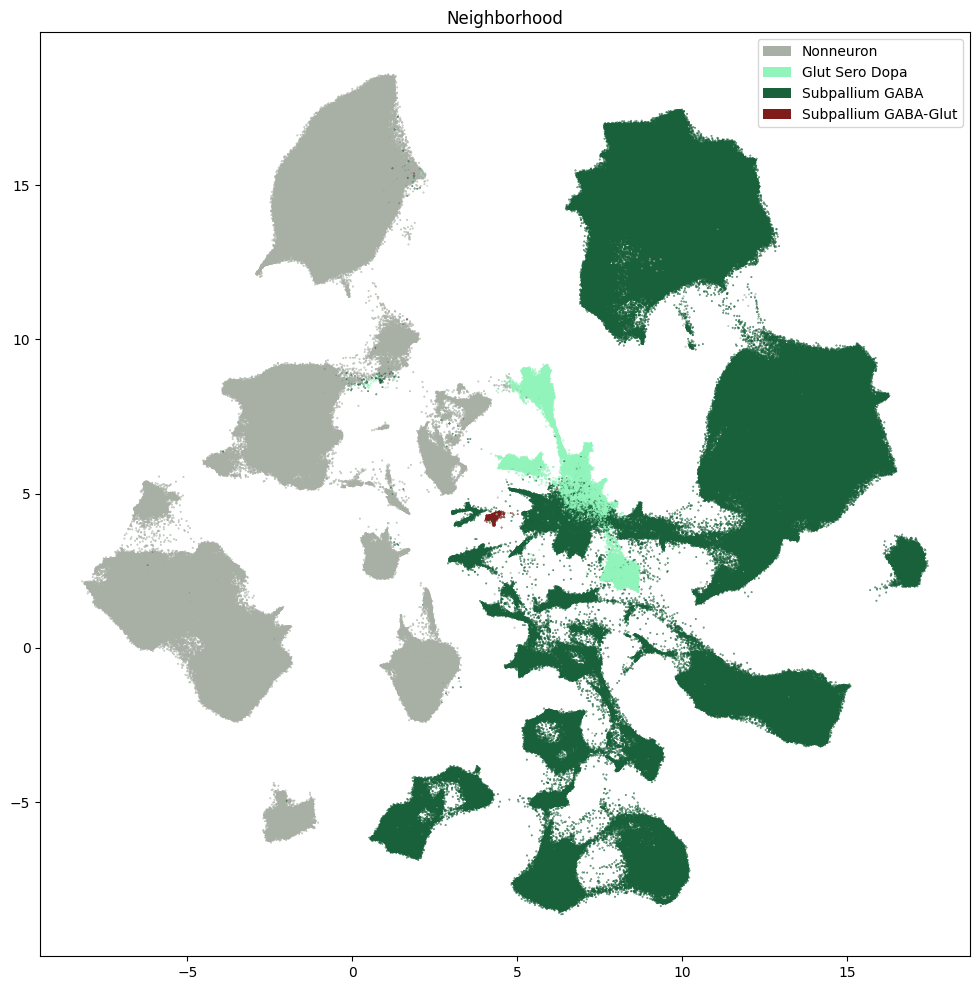

In [35]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Neighborhood_color'],
    labels=cell_extended['Neighborhood'],
    term_orders=cell_extended['Neighborhood_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Neighborhood")
plt.show()

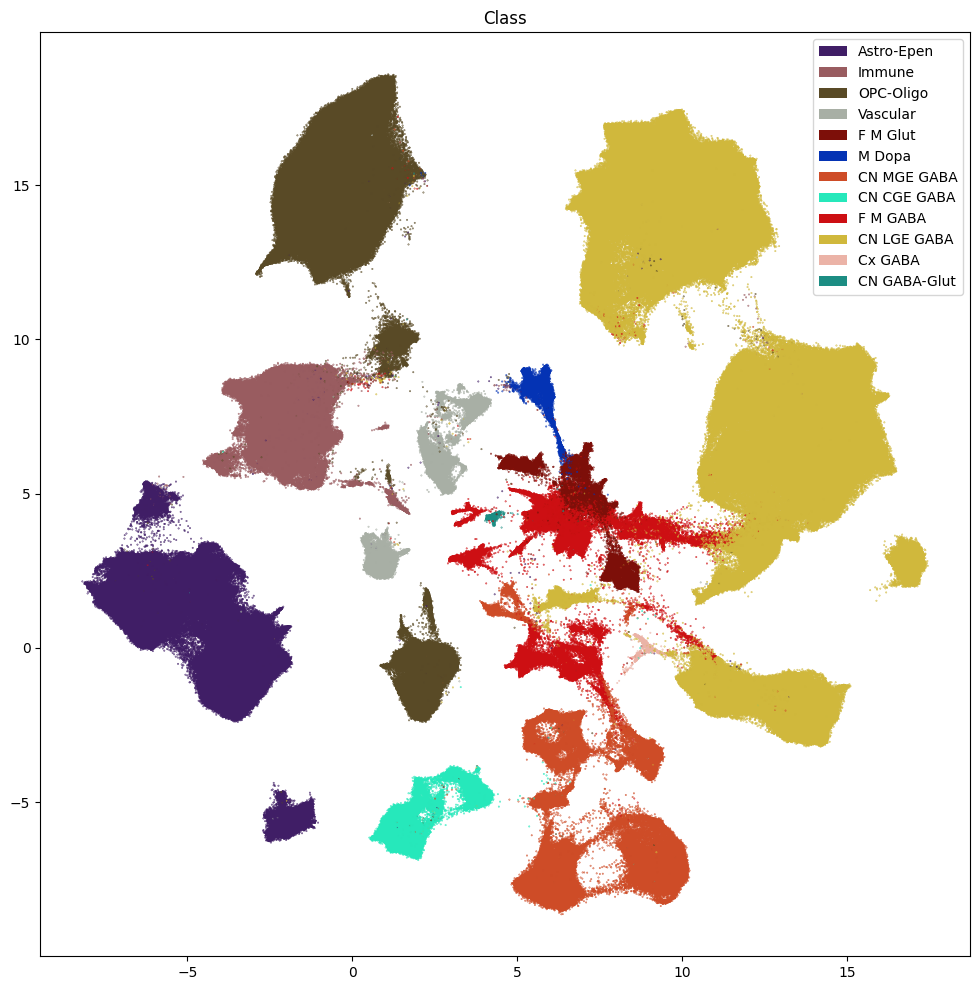

In [36]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Class_color'],
    labels=cell_extended['Class'],
    term_orders=cell_extended['Class_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Class")
plt.show()

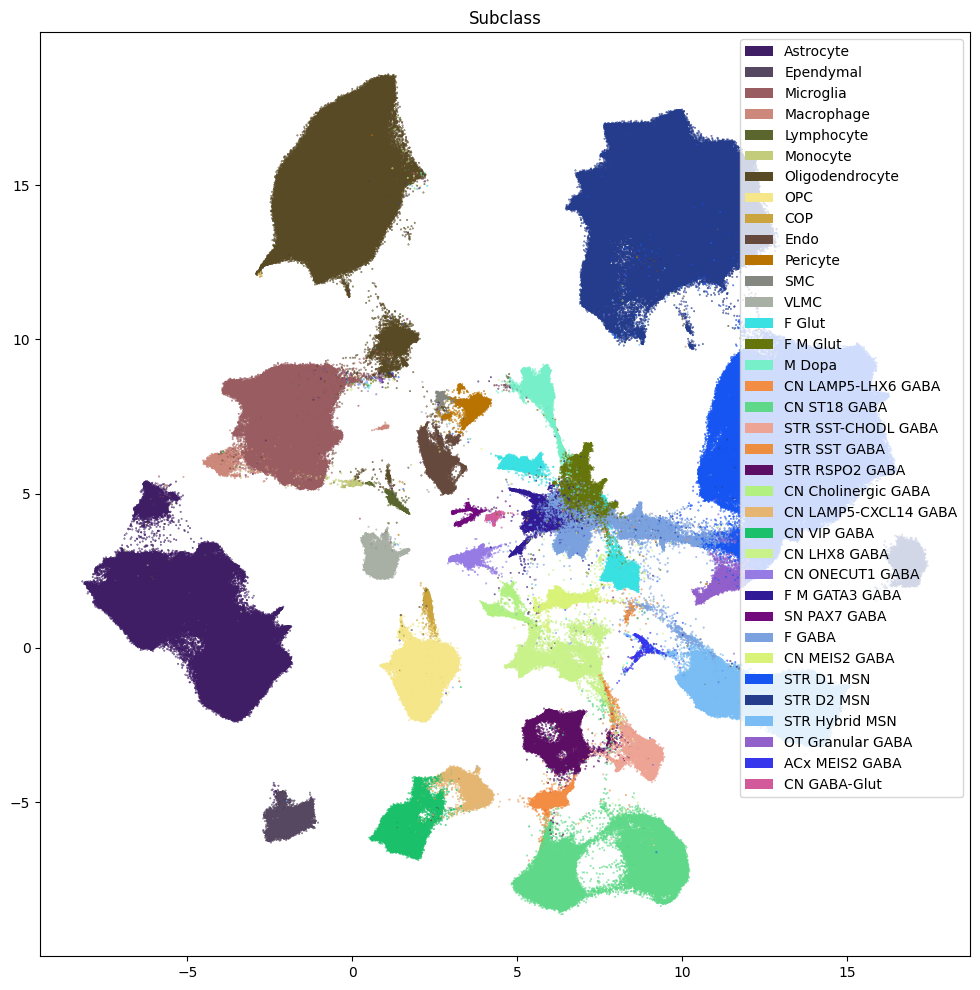

In [37]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Subclass_color'],
    labels=cell_extended['Subclass'],
    term_orders=cell_extended['Subclass_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Subclass")
plt.show()

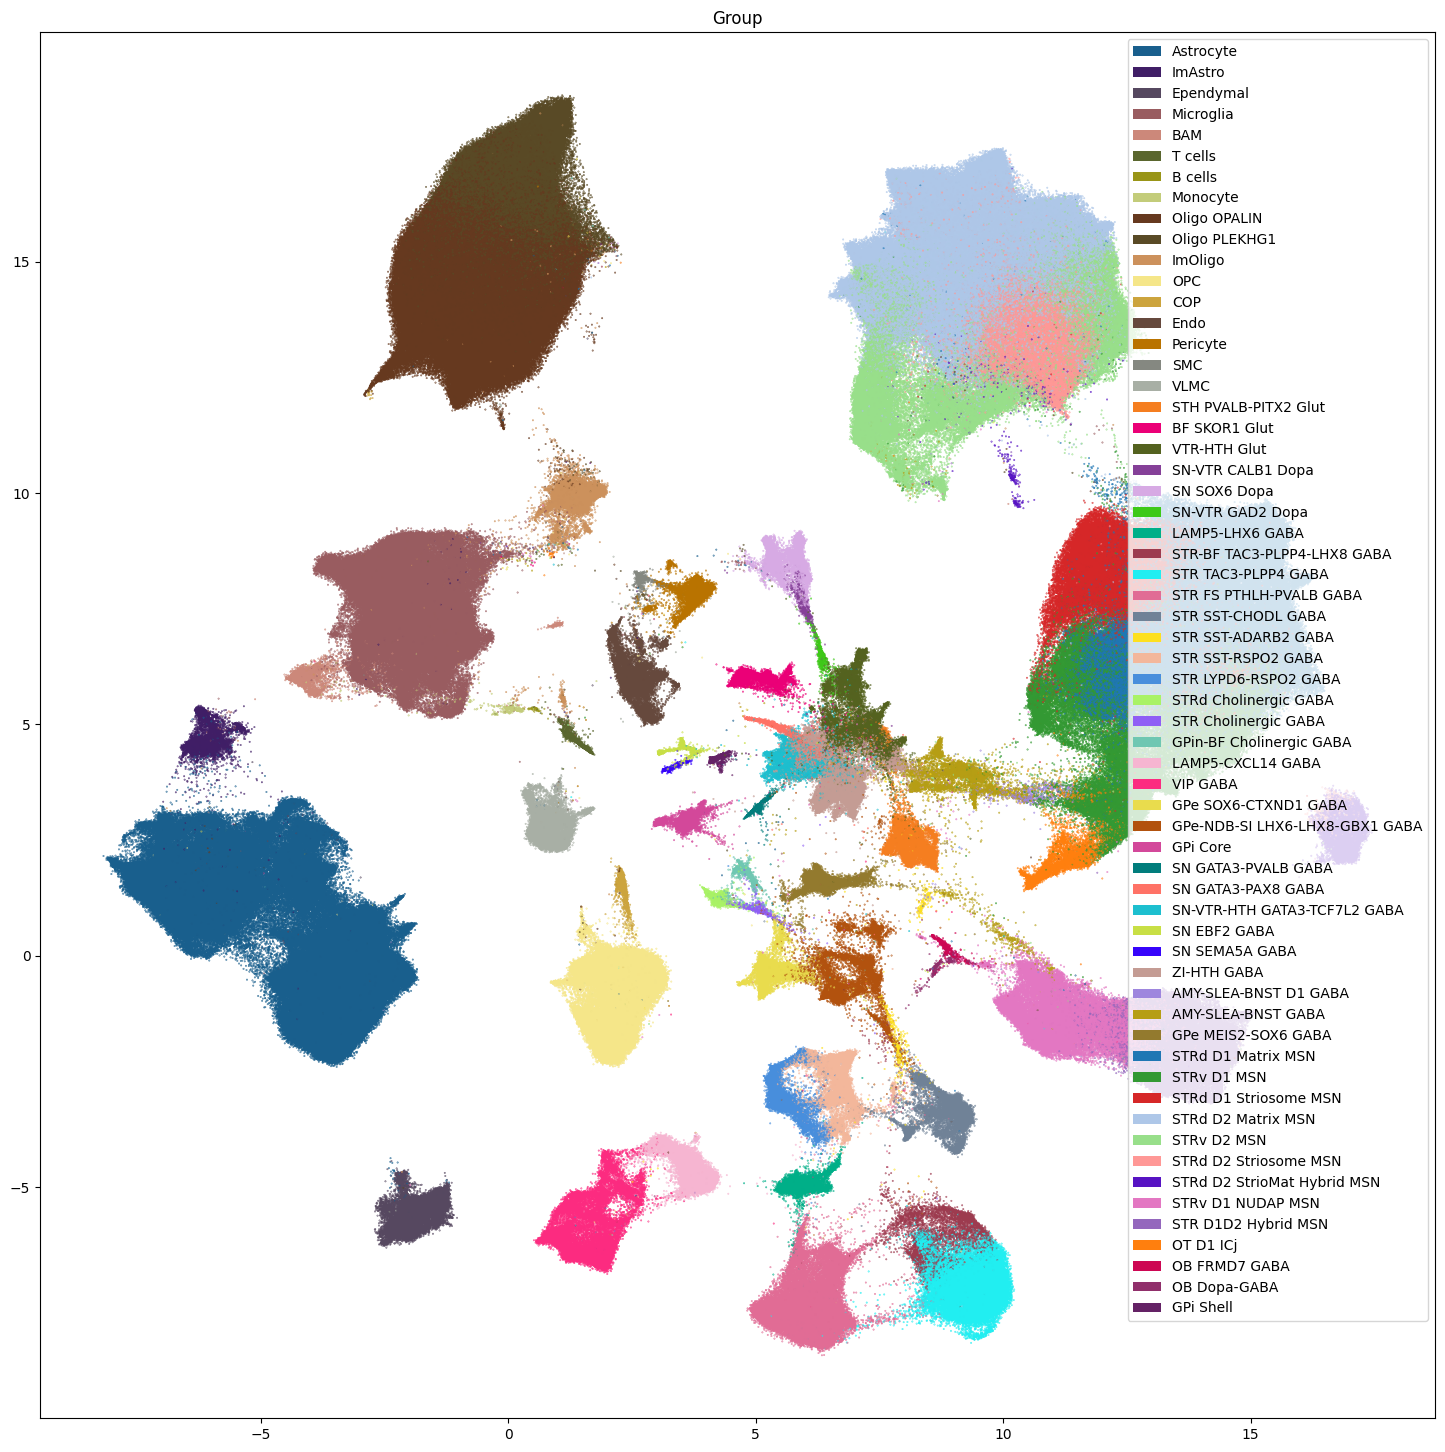

In [38]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Group_color'],
    labels=cell_extended['Group'],
    term_orders=cell_extended['Group_order'],
    fig_width=18,
    fig_height=18
)
res = ax.set_title("Group")
plt.show()

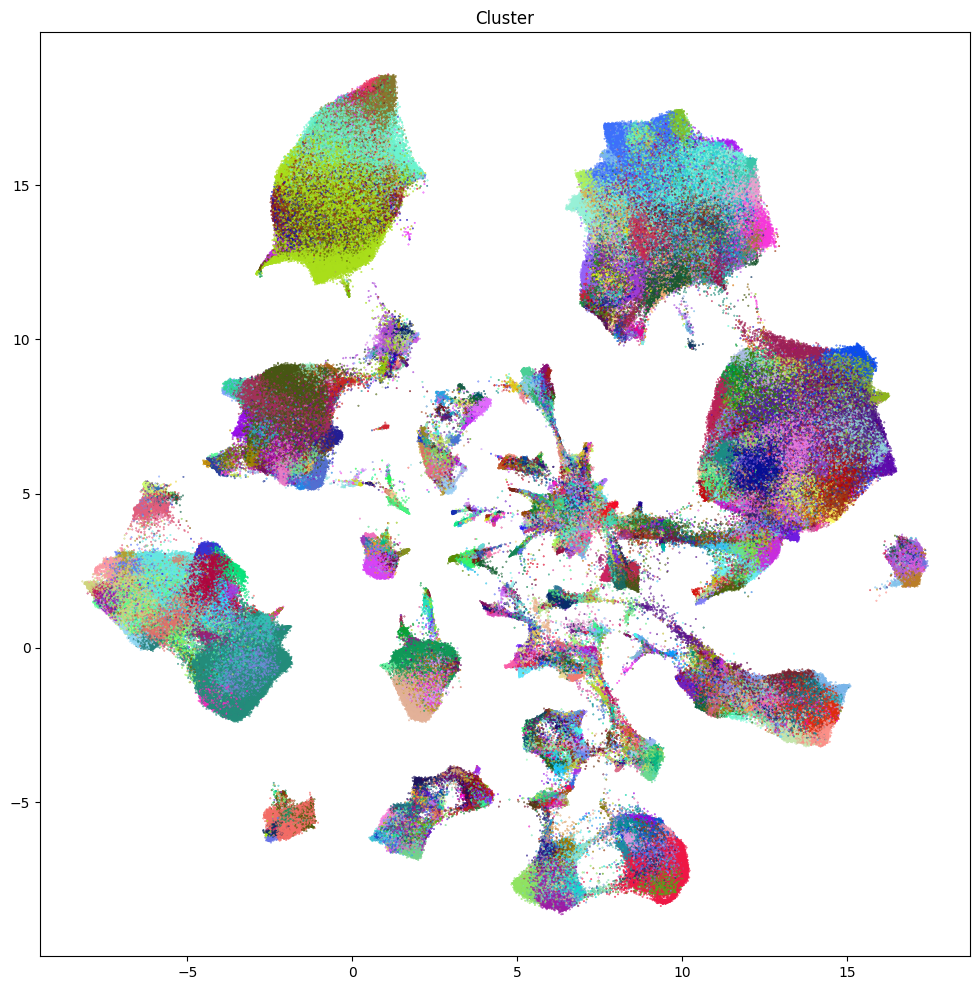

In [39]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['Cluster_color'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Cluster")
plt.show()

### Aggregating cluster and cells counts per term

Let's investigate the taxonomy information a bit more. In this section, we'll create bar plots showing the number of clusters and cells at each level in the taxonomy. 

First, we need to compute the number of clusters that are in each of the cell type taxons above it.

In [40]:
# Count the number of clusters associated with each cluster annotation term
term_cluster_count = membership_with_cluster_info.reset_index().groupby(['cluster_annotation_term_label'])[['cluster_alias']].count()
term_cluster_count.columns = ['number_of_clusters']
term_cluster_count.head()

number_of_clusters
cluster_annotation_term_label                    
CS20250428_CLASS_0000                          86
CS20250428_CLASS_0001                          93
CS20250428_CLASS_0002                          12
CS20250428_CLASS_0003                         386
CS20250428_CLASS_0005                         199

We already have our number of cells computed previously, so we'll just use them here and cluster counts into the cluster_annotation table.

In [41]:
# Join counts with the term dataframe
term_with_counts = cluster_annotation_term_with_cells.join(term_cluster_count)
term_with_counts[['name', 'cluster_annotation_term_set_name', 'number_of_clusters', 'number_of_cells']].head()

name  \
cluster_annotation_term_label                         
CS20250428_NEIGH_0001                     Nonneuron   
CS20250428_NEIGH_0000                Glut Sero Dopa   
CS20250428_NEIGH_0002               Subpallium GABA   
CS20250428_NEIGH_0003          Subpallium GABA-Glut   
CS20250428_CLASS_0000                    Astro-Epen   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20250428_NEIGH_0001                             Neighborhood   
CS20250428_NEIGH_0000                             Neighborhood   
CS20250428_NEIGH_0002                             Neighborhood   
CS20250428_NEIGH_0003                             Neighborhood   
CS20250428_CLASS_0000                                    Class   

                               number_of_clusters  number_of_cells  
cluster_annotation_term_label                                       
CS20250428_NEIGH_0001                         295           815521  
CS20250428_NEIGH_0000                         171            34315  
CS20250428_NEIGH_0002                         957          1045252  
CS20250428_NEIGH_0003                          12             1045  
CS20250428_CLASS_0000                          86           224824

Below we create a function to plot the cluster and cell counts in a bar graph, coloring by the associated taxon level.

In [42]:
def bar_plot_by_level_and_type(df: pd.DataFrame, level: str, fig_width: float = 8.5, fig_height: float = 4):
    """Plot the number of clusters and cells by the specified level.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cluster annotation terms with counts.
    level : str
        The level of the taxonomy to plot (e.g., 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster').
    fig_width : float, optional
        Width of the figure in inches. Default is 8.5.
    fig_height : float, optional
        Height of the figure in inches. Default is 4.
    """

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(fig_width, fig_height)
    
    for idx, ctype in enumerate(['clusters', 'cells']):

        pred = (df['cluster_annotation_term_set_name'] == level)
        sort_order = np.argsort(df[pred]['term_order'])
        names = df[pred]['name'].iloc[sort_order]
        counts = df[pred]['number_of_%s' % ctype].iloc[sort_order]
        colors = df[pred]['color_hex_triplet'].iloc[sort_order]
        
        ax[idx].barh(names, counts, color=colors)
        ax[idx].set_title('Number of %s by %s' % (ctype,level)),
        ax[idx].set_xscale('log')
        
        if idx > 0:
            ax[idx].set_yticklabels([])

    plt.show()

Now let's plot the counts for each of the taxonomy levels above Cluster.

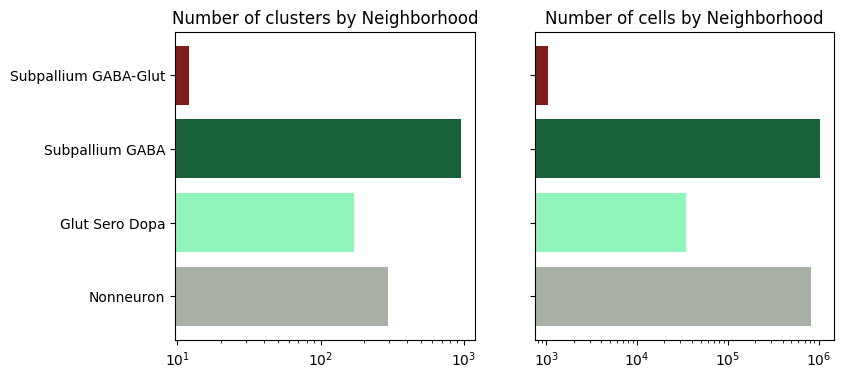

In [43]:
bar_plot_by_level_and_type(term_with_counts, 'Neighborhood')
plt.show()

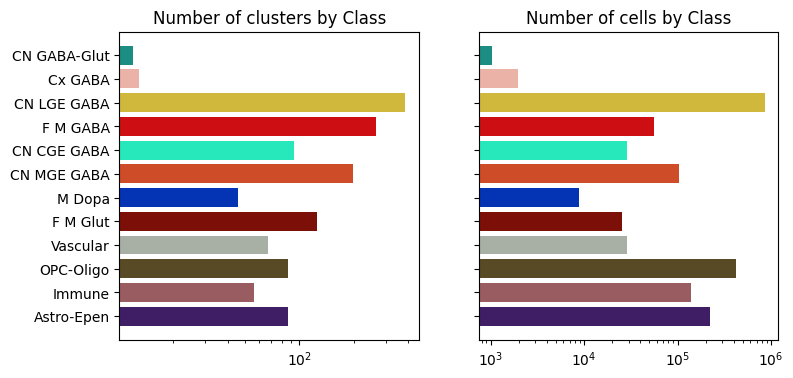

In [44]:
bar_plot_by_level_and_type(term_with_counts, 'Class')
plt.show()

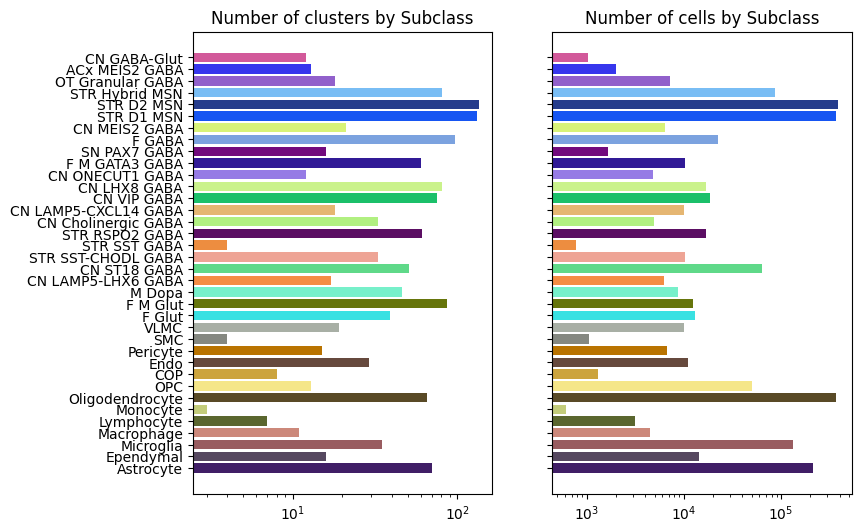

In [45]:
bar_plot_by_level_and_type(term_with_counts, 'Subclass', 8.5, 6)
plt.show()

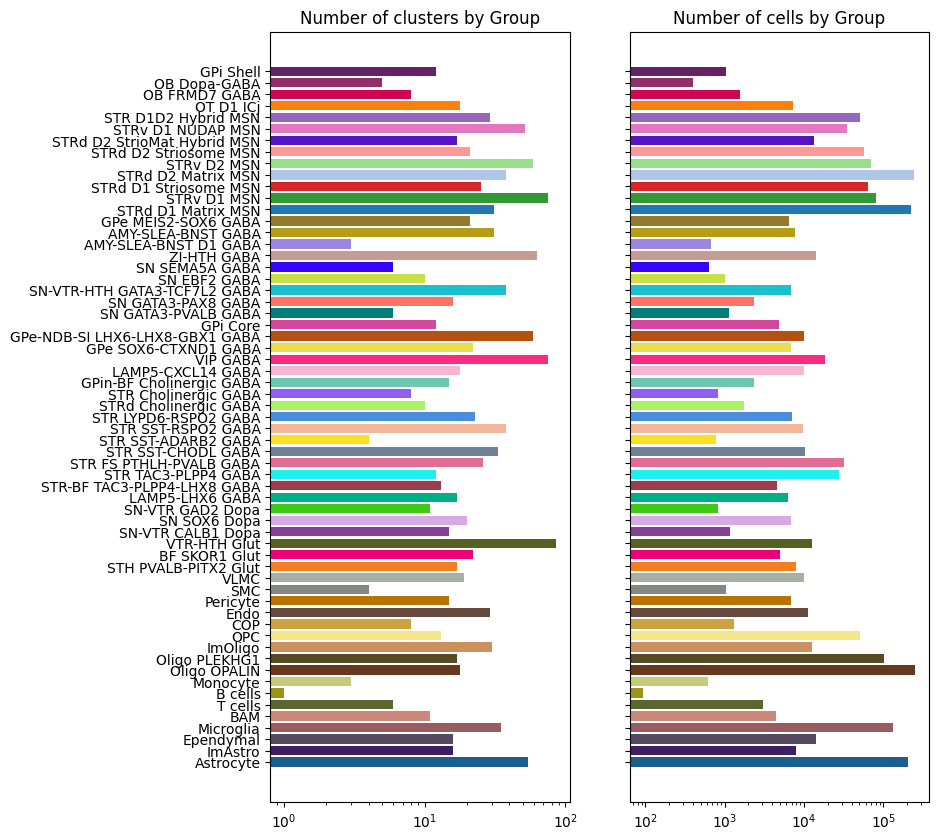

In [46]:
bar_plot_by_level_and_type(term_with_counts, 'Group', 8.5, 10)
plt.show()

#### Distribution of lower taxonomy levels in their parents.

We can also use a similar visualization to show a given taxonomy level in another. Below we define functions to manipulate our data and plot a stacked bar plot.

In [47]:
def distribution(A: str, B: str) -> Tuple[pd.DataFrame, list, list]:
    """Compute the distribution of clusters across two levels of the taxonomy.

    Parameters
    ----------
    A : str
        The higher level of the taxonomy (e.g., 'Neighborhood', 'Class', 'Subclass', 'Group').
    B : str
        The lower level of the taxonomy (e.g., 'Class', 'Subclass', 'Group', 'Cluster').

    Returns
    -------
    AxB : pd.DataFrame
        A DataFrame where the index is the unique values of A and the columns are the unique values of B.
        The values are the number of clusters that are associated with each combination of A and B.
    B_names : list
        The names of the B levels in the order they appear in the columns of AxB.
    B_colors : list
        The colors of the B levels in the order they appear in the columns of AxB.
    """

    cluster_order_details = cluster_details.join(cluster_order)
    
    AxB = cluster_details.groupby([A, B])[['Cluster']].count()
    AxB.columns = ['number_of_clusters']
    AxB = AxB.unstack().fillna(0)
    AxB = AxB.loc[
        cluster_order_details[A].unique()[
            np.argsort(cluster_order_details[f'{A}_order'].unique())
        ]
    ]
    AxB = AxB[[
            ('number_of_clusters', name)
            for name in cluster_order_details[B].unique()[
                np.argsort(cluster_order_details[f'{B}_order'].unique())
            ]
    ]]

    B_names = [x[1] for x in list(AxB.columns)]
    pred = (cluster_annotation_term_with_cells['cluster_annotation_term_set_name'] == B)
    term_by_name = cluster_annotation_term_with_cells[pred].set_index('name')
    B_colors = term_by_name.loc[B_names, 'color_hex_triplet']
    
    return AxB, B_names, B_colors

In [48]:
def stacked_bar_distribution(AxB: pd.DataFrame, B_colors: list, fig_width = 6, fig_height = 6):
    """Plot a stacked horizontal bar chart of the distribution of B levels in each A level.

    Parameters
    ----------
    AxB : pd.DataFrame
        A DataFrame where the index is the unique values of A and the columns are the unique values of B.
        The values are the number of clusters that are associated with each combination of A and B.
    B_colors : list
        The colors of the B levels in the order they appear in the columns of AxB.
    fig_width : float, optional
        Width of the figure in inches. Default is 6.
    fig_height : float, optional
        Height of the figure in inches. Default is 6.
    """

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    bottom = np.zeros(len(AxB))

    for i, col in enumerate(AxB.columns):
        ax.barh(AxB.index[::-1], AxB[col][::-1], left=bottom, label=col[1], color=B_colors[i])
        bottom += np.array(AxB[col][::-1])

    ax.set_title('Distribution of %s in each %s' % (AxB.columns.names[1], AxB.index.name))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
    return fig, ax

We can now visualize how each lower level in the taxonomy is distributed by cluster in the upper portions of the taxonomy.

/var/folders/kc/7glrmt5n67x16yj_tg86t49c0000gp/T/ipykernel_88044/2706381520.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.barh(AxB.index[::-1], AxB[col][::-1], left=bottom, label=col[1], color=B_colors[i])


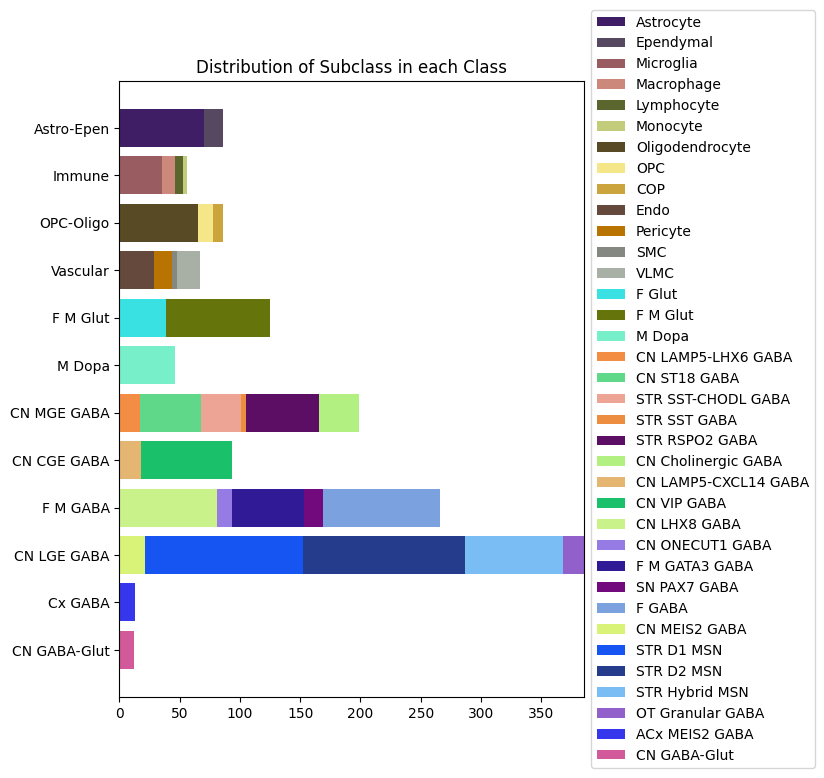

In [49]:
AxB, B_names, B_colors = distribution('Class', 'Subclass')
fig, ax = stacked_bar_distribution(AxB, B_colors, 6, 8)
plt.show()

### Visualizing the BG taxonomy

Term sets: Class, Subclass, Group and Cluster forms a four level Basil Ganglia taxonomy. We can visualize the taxonomy as a sunburst diagram that shows the single inheritance hierarchy through a series of rings, that are sliced for each annotation term. Each ring corresponds to a level in the hierarchy. We have ordered the rings so that the Class level is the outer most ring so that we can add in labels. Rings are sliced up and divided based on their hierarchical relationship to the parent slice. The angle of each slice is proportional to the number of clusters belonging to the term. Note that we exclude Neighborhood here as it is a much less interesting plot.

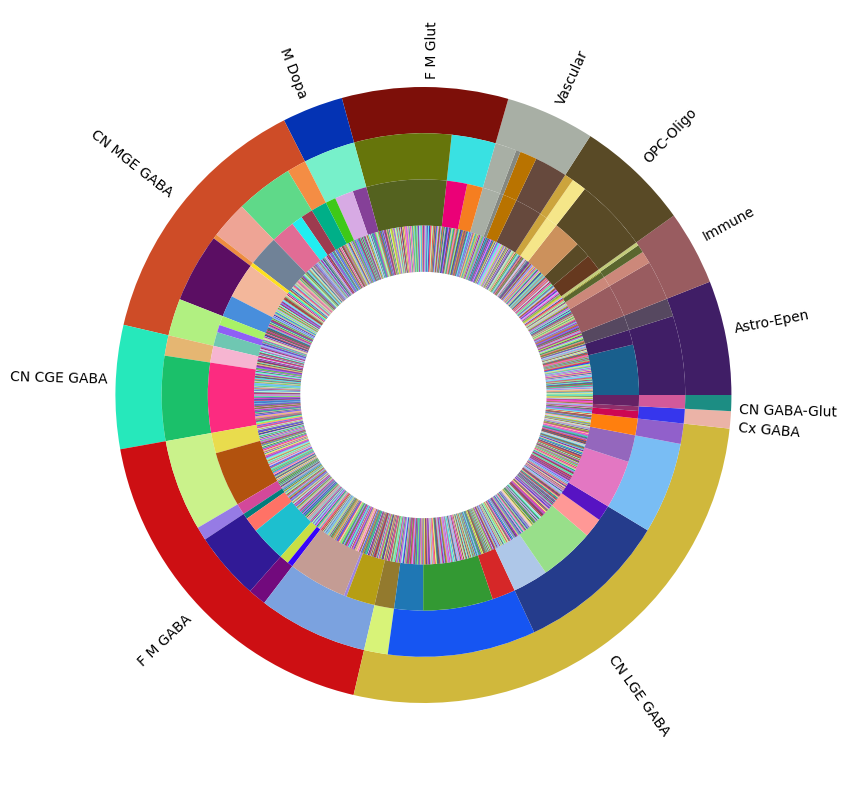

In [ ]:
levels = ['Class', 'Subclass', 'Group', 'Cluster']
df = {}

# Copy the term order of the parent into each of the level below it.
term_with_counts['parent_order'] = ""
for idx, row in term_with_counts.iterrows():
    if pd.isna(row['parent_term_label']):
        continue
    term_with_counts.loc[idx, 'parent_order'] = term_with_counts.loc[row['parent_term_label']]['term_order']

term_with_counts = term_with_counts.reset_index()
for lvl in levels:
    pred = term_with_counts['cluster_annotation_term_set_name'] == lvl
    df[lvl] = term_with_counts[pred]
    df[lvl] = df[lvl].sort_values(['parent_order', 'term_order'])

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
size = 0.15

for i, lvl in enumerate(levels):
    
    if lvl == 'Class':
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               labels = df[lvl]['name'],
               rotatelabels=True,
               labeldistance=1.025,
               radius=1,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
    else :
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               radius=1-i*size,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)

plt.show()

In the next tutorial, we show how to access and use [HMBA-BG gene expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_10X_snRNASeq_tutorial.html).

To see how this taxonomy can is used in spatial transcriptomic data, see the take look at the [HBMA-BG Spatial Slabs and Taxonomy notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_spatial_slabs_and_taxonomy.html).